<a href="https://colab.research.google.com/github/beatrizsv515/eShopOnWeb/blob/main/Automatosv6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import os
import seaborn as sns
import shap

from math import ceil, sqrt
from scipy.spatial import KDTree
from sklearn.neighbors import KDTree


from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from matplotlib.colors import ListedColormap
from scipy.stats import ttest_rel, wilcoxon

In [40]:
pd.set_option('display.max_columns', None)

In [41]:
df_final_covid = pd.read_csv(
    '/content/df_final_covid.csv',
    sep=',',
    decimal='.',
    parse_dates=['date'],
    dayfirst=False
)

In [42]:
df_final_covid['date'] = pd.to_datetime(df_final_covid['date'])

df_final_covid['ano_mes'] = df_final_covid['date'].dt.to_period('M').astype(str)

df_covid = df_final_covid.copy()
df_covid['ano_mes'] = pd.to_datetime(df_covid['ano_mes'])

df_covid['meses_desde_2020'] = ((df_covid['ano_mes'].dt.year - 2020) * 12) + (df_covid['ano_mes'].dt.month - 1)

df_covid['pop_interpolada'] = df_covid['pop2020'] + (df_covid['pop2021'] - df_covid['pop2020']) * (df_covid['meses_desde_2020'] / 12)

df_covid['pop_interpolada'] = df_covid['pop_interpolada'].round().astype(int)

df_covif_pop_interpolada = df_covid.copy()

In [43]:
df_filtrado = df_covif_pop_interpolada[df_covif_pop_interpolada['date'] >= '2020-05-01'].copy()

In [44]:
cols_para_preencher = [
    'transit_stations_percent_change_from_baseline',
    'parks_percent_change_from_baseline',
    'retail_and_recreation_percent_change_from_baseline',
    'grocery_and_pharmacy_percent_change_from_baseline',
    'residential_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline',
    'UMIDADE_MAX', 'UMIDADE_MIN', 'UMIDADE_MEAN',
    'TEMPERATURA_MIN', 'TEMPERATURA_MAX', 'TEMPERATURA_MEAN',
    'PRESSAO_MIN', 'PRESSAO_MAX', 'PRESSAO_MEAN'
]

# Ordenar os dados por cidade e data para manter a sequência temporal correta
df_filtrado.sort_values(by=['city', 'date'], inplace=True)

# Preencher nulos por cidade (com transform, que preserva o índice)
for col in cols_para_preencher:
    df_filtrado[col] = (
        df_filtrado
        .groupby('city')[col]
        .transform(lambda x: x.ffill().bfill())
    )

In [45]:
df_filtrado_maior100k = df_filtrado[df_filtrado['pop_interpolada'] > 100000]

df_filtrado_maior100k['VL_ALTITUDE'] = (
    df_filtrado_maior100k['VL_ALTITUDE']
    .str.replace(',', '.', regex=False)
)

df_filtrado_maior100k['VL_ALTITUDE'] = df_filtrado_maior100k['VL_ALTITUDE'].astype(float)

/tmp/ipython-input-45-459522733.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado_maior100k['VL_ALTITUDE'] = (
/tmp/ipython-input-45-459522733.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado_maior100k['VL_ALTITUDE'] = df_filtrado_maior100k['VL_ALTITUDE'].astype(float)


In [46]:
df_filtrado_maior100k['newCases_last14d'] = (
    df_filtrado_maior100k
    .groupby('city')['newCases']
    .transform(lambda x: x.shift(1).rolling(14, min_periods=1).sum())
)

df_filtrado_maior100k['newDeaths_last14d'] = (
    df_filtrado_maior100k
    .groupby('city')['newDeaths']
    .transform(lambda x: x.shift(1).rolling(14, min_periods=1).sum())
)

df_filtrado_maior100k['cases_per_100k'] = df_filtrado_maior100k['newCases'].shift(1) / df_filtrado_maior100k['pop_interpolada'] * 100000
df_filtrado_maior100k['deaths_per_100k'] = df_filtrado_maior100k['newDeaths'].shift(1) / df_filtrado_maior100k['pop_interpolada'] * 100000

df_filtrado_maior100k['caseslast14d_per_100k'] = df_filtrado_maior100k['newCases_last14d'] / df_filtrado_maior100k['pop_interpolada'] * 100000
df_filtrado_maior100k['deathslast14d_per_100k'] = df_filtrado_maior100k['newDeaths_last14d'] / df_filtrado_maior100k['pop_interpolada'] * 100000

/tmp/ipython-input-46-1785988866.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado_maior100k['newCases_last14d'] = (
/tmp/ipython-input-46-1785988866.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado_maior100k['newDeaths_last14d'] = (
/tmp/ipython-input-46-1785988866.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [47]:
df_filtrado_maior100k['impostos_liquidos_per_capita'] = (
    df_filtrado_maior100k['impostos_liquidos'] / df_filtrado_maior100k['pop2020']
)

df_filtrado_maior100k['suscetiveis'] = (df_filtrado_maior100k['pop_interpolada'] - df_filtrado_maior100k['newCases_last14d'])

# 1. Interação: suscetíveis × mobilidade
df_filtrado_maior100k['interacao_grocery'] = df_filtrado_maior100k['suscetiveis'] * df_filtrado_maior100k['grocery_and_pharmacy_percent_change_from_baseline']
df_filtrado_maior100k['interacao_retail'] = df_filtrado_maior100k['suscetiveis'] * df_filtrado_maior100k['retail_and_recreation_percent_change_from_baseline']

# 2. Taxa de crescimento com base no valor do dia anterior
df_filtrado_maior100k['taxa_crescimento_14d'] = (
    df_filtrado_maior100k['newCases'].shift(1) / df_filtrado_maior100k['newCases_last14d']
) - 1

# 3. Média móvel de 7 dias (excluindo o dia atual)
df_filtrado_maior100k['media_movel_7d'] = (
    df_filtrado_maior100k.groupby('city')['newCases']
    .transform(lambda x: x.shift(1).rolling(window=7, min_periods=1).mean())
)

# Adiciona coluna de dia da semana (segunda = 0, domingo = 6)
df_filtrado_maior100k['weekday'] = pd.to_datetime(df_filtrado_maior100k['date']).dt.dayofweek
df_filtrado_maior100k = pd.get_dummies(df_filtrado_maior100k, columns=['weekday'], prefix='wd', drop_first=True)

df_filtrado_maior100k = df_filtrado_maior100k.fillna(0)

/tmp/ipython-input-47-2134526714.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado_maior100k['impostos_liquidos_per_capita'] = (
/tmp/ipython-input-47-2134526714.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado_maior100k['suscetiveis'] = (df_filtrado_maior100k['pop_interpolada'] - df_filtrado_maior100k['newCases_last14d'])
/tmp/ipython-input-47-2134526714.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

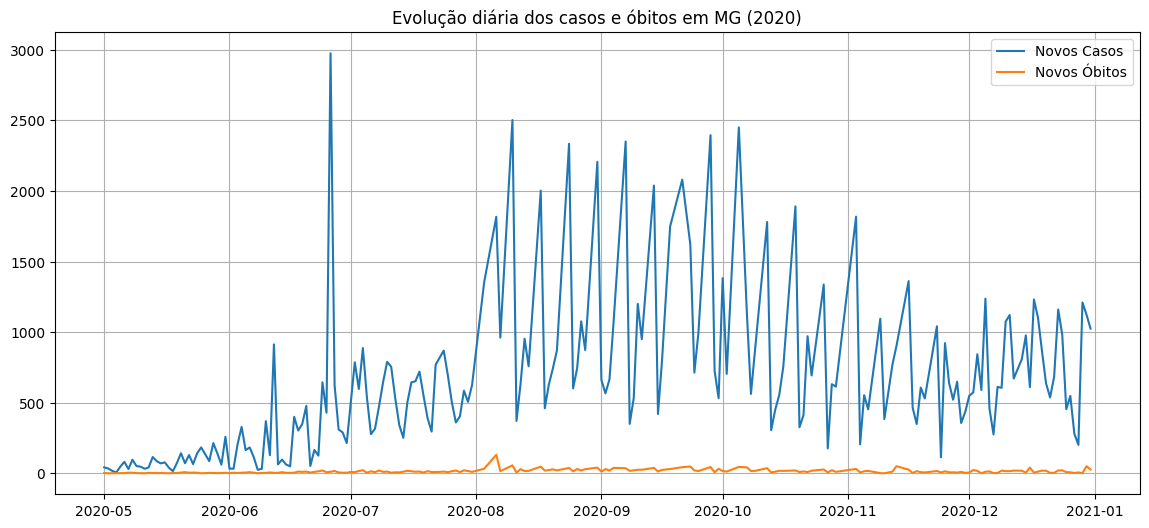

In [48]:
# Agregar por data (todos os municípios juntos)
df_daily = df_filtrado_maior100k.groupby('date')[['newCases', 'newDeaths']].sum().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(df_daily['date'], df_daily['newCases'], label='Novos Casos')
plt.plot(df_daily['date'], df_daily['newDeaths'], label='Novos Óbitos')
plt.title('Evolução diária dos casos e óbitos em MG (2020)')
plt.legend()
plt.grid(True)
plt.show()

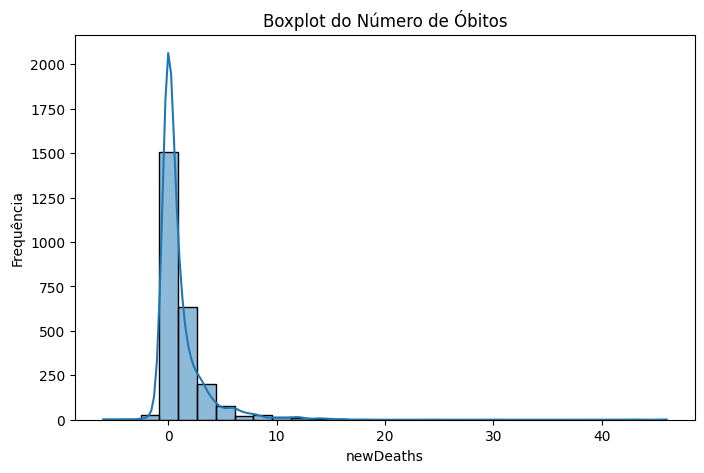

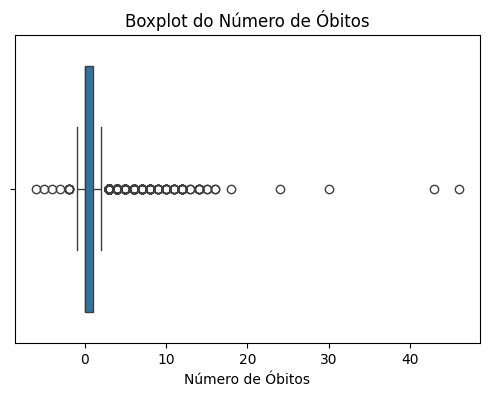

In [49]:
# Histograma do Número de óbitos

plt.figure(figsize=(8, 5))
sns.histplot(df_filtrado_maior100k['newDeaths'], bins=30, kde=True)
plt.title('Distribuição do  Número de Óbitos')
plt.title('Boxplot do Número de Óbitos')
plt.ylabel('Frequência')
plt.show()

# Boxplot para ver outliers e distribuição
plt.figure(figsize=(6, 4))
sns.boxplot(x=df_filtrado_maior100k['newDeaths'])
plt.title('Boxplot do Número de Óbitos')
plt.xlabel('Número de Óbitos')
plt.show()

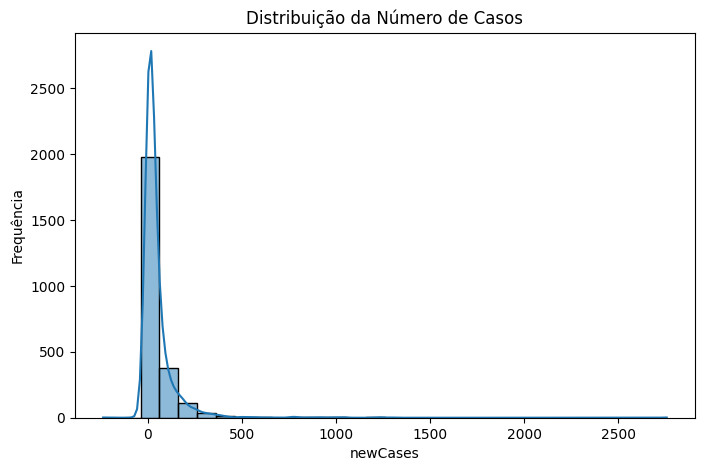

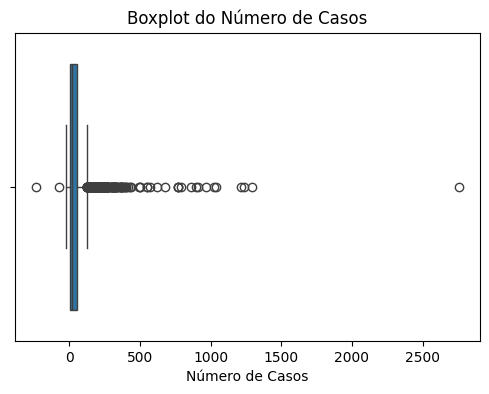

In [50]:
# Histograma do Número de Casos

plt.figure(figsize=(8, 5))
sns.histplot(df_filtrado_maior100k['newCases'], bins=30, kde=True)
plt.title('Distribuição da Número de Casos')
plt.title('Distribuição da Número de Casos')
plt.ylabel('Frequência')
plt.show()

# Boxplot para ver outliers e distribuição
plt.figure(figsize=(6, 4))
sns.boxplot(x=df_filtrado_maior100k['newCases'])
plt.title('Boxplot do Número de Casos')
plt.xlabel('Número de Casos')
plt.show()

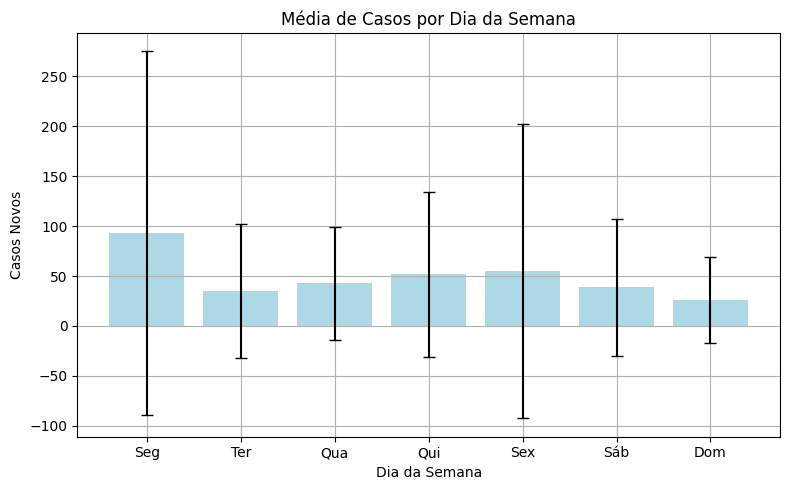

In [51]:
df_filtrado_maior100k['weekday'] = pd.to_datetime(df_filtrado_maior100k['date']).dt.dayofweek

# Média e desvio por dia da semana
media_por_dia = df_filtrado_maior100k.groupby('weekday')['newCases'].mean()
desvio_por_dia = df_filtrado_maior100k.groupby('weekday')['newCases'].std()

# Plot
import matplotlib.pyplot as plt

dias = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']

plt.figure(figsize=(8, 5))
plt.bar(dias, media_por_dia, yerr=desvio_por_dia, color='lightblue', capsize=4)
plt.title('Média de Casos por Dia da Semana')
plt.ylabel('Casos Novos')
plt.xlabel('Dia da Semana')
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
colunas_modelo = [
       'PRESSAO_MEAN', 'PRESSAO_MAX', 'PRESSAO_MIN',
       'TEMPERATURA_MEAN', 'TEMPERATURA_MAX', 'TEMPERATURA_MIN',
       'UMIDADE_MEAN', 'UMIDADE_MAX', 'UMIDADE_MIN',
       'VL_ALTITUDE',
       'impostos_liquidos_per_capita',
       'pib_per_capita',
       'total_covid_internados',
       'retail_and_recreation_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'residential_percent_change_from_baseline',
       'newCases_last14d',
       'newDeaths_last14d',
       'deaths_per_100k',
        'suscetiveis', 'interacao_grocery',
       'interacao_retail',
       'taxa_crescimento_14d', 'media_movel_7d',
        'wd_1', 'wd_2', 'wd_3', 'wd_4', 'wd_5', 'wd_6', 'weekday'
        ]

# 1. Seleciona colunas de preditoras + target + date
df_model = df_filtrado_maior100k[colunas_modelo + ['newCases', 'date']].copy()

# 2. Remove linhas com qualquer NaN nas colunas do modelo ou em newCases
df_model = df_model.dropna(subset=colunas_modelo + ['newCases'])

# 3. Cria target transformado pela raiz quadrada
df_model['sqrt_newCases'] = np.sqrt(df_model['newCases'])

# 4. Remove eventuais NaN ou inf gerados
mask = np.isfinite(df_model['sqrt_newCases'])
df_model = df_model.loc[mask].reset_index(drop=True)

# X e y completos antes da seleção
X_full = df_model[colunas_modelo]
y_full = df_model['sqrt_newCases']

# Seleção com RFECV
modelo_base = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

rfecv = RFECV(
    estimator=modelo_base,
    step=1,
    cv=cv,
    scoring='neg_mean_squared_error',
    min_features_to_select=1,
    n_jobs=-1
)

rfecv.fit(X_full, y_full)

print(f"Melhor número de features selecionadas pelo RFECV: {rfecv.n_features_}")
selected_features = X_full.columns[rfecv.support_]
print("Features selecionadas:", list(selected_features))

X = df_model[selected_features]
y = df_model['sqrt_newCases']
dates = df_model['date']

# Divisão treino/teste mantendo índices
X_train, X_test, y_train, y_test, date_train, date_test = train_test_split(
    X, y, dates,
    test_size=0.2,
    random_state=42,
    shuffle=True
)


modelo = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
modelo.fit(X_train, y_train)

# Previsões
y_pred_sqrt_train = modelo.predict(X_train)
y_pred_sqrt_test = modelo.predict(X_test)

# Reverter transformação (raiz ao quadrado)
y_train_orig = np.square(y_train)
y_test_orig = np.square(y_test)
y_pred_orig_train = np.square(y_pred_sqrt_train)
y_pred_orig_test = np.square(y_pred_sqrt_test)

# Métricas
mse = mean_squared_error(y_test_orig, y_pred_orig_test)
rmse = np.sqrt(mse)
r2_train = r2_score(y_train_orig, y_pred_orig_train)
r2_test = r2_score(y_test_orig, y_pred_orig_test)

print(f'RMSE no Teste: {rmse:.2f}')
print(f'R² no Treino: {r2_train:.2f}')
print(f'R² no Teste: {r2_test:.2f}')

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Melhor número de features selecionadas pelo RFECV: 32
Features selecionadas: ['PRESSAO_MAX', 'PRESSAO_MIN', 'TEMPERATURA_MEAN', 'TEMPERATURA_MIN', 'UMIDADE_MEAN', 'UMIDADE_MAX', 'UMIDADE_MIN', 'VL_ALTITUDE', 'impostos_liquidos_per_capita', 'pib_per_capita', 'total_covid_internados', 'retail_and_recreation_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'residential_percent_change_from_baseline', 'newCases_last14d', 'newDeaths_last14d', 'deaths_per_100k', 'suscetiveis', 'interacao_grocery', 'interacao_retail', 'taxa_crescimento_14d', 'media_movel_7d', 'wd_1', 'wd_2', 'wd_3', 'wd_4', 'wd_5', 'wd_6', 'weekday']
RMSE no Teste: 59.36
R² no Treino: 0.97
R² no Teste: 0.58


In [53]:
# 1. Usa só as features selecionadas para o próximo passo
features = list(selected_features)

# 2. Definir X e y
df_model = df_filtrado_maior100k.copy()

# Remover valores negativos ou nulos antes da transformação
df_model = df_model[df_model['newCases'] >= 0].copy()
df_model = df_model.dropna(subset=features + ['newCases'])

X = df_model[features]
y = np.sqrt(df_model['newCases'])


# 3. Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,  shuffle=True)

# 4. Hiperparâmetros
parametros = {
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [3, 5]},
    'XGBoost': {'n_estimators': [100, 300], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]},
    'Gradient Boosting': {'n_estimators': [100, 300], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]},
    'HistGradientBoosting': {'max_iter': [100, 300], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]},
    'Extra Trees': {'n_estimators': [100, 300], 'max_depth': [3, 5]}
}

# 5. Modelos base
modelos_base = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42)
}


# 6. Avaliação
resultados = []
modelos_treinados = {}

for nome, modelo in modelos_base.items():
    print(f"Avaliando {nome}...")
    grid = GridSearchCV(modelo, parametros[nome], cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    melhor_modelo = grid.best_estimator_
    modelos_treinados[nome] = melhor_modelo

   # Previsão em escala original (revertendo a raiz quadrada)
    y_pred_sqrt = melhor_modelo.predict(X_test)
    y_pred = np.square(y_pred_sqrt)
    y_real = np.square(y_test)


    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)

    resultados.append({
        'Modelo': nome,
        'Melhores Params': grid.best_params_,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    })

# 7. Tabela de resultados
df_resultados = pd.DataFrame(resultados).sort_values(by='RMSE')
print("\nResultados:")
print(df_resultados)

# 8. Selecionar o melhor modelo
melhor_nome_modelo = df_resultados.iloc[0]['Modelo']
melhor_modelo_treinado = modelos_treinados[melhor_nome_modelo]

print(f"\n Melhor modelo: {melhor_nome_modelo}")
print(f"Parâmetros ótimos: {df_resultados.iloc[0]['Melhores Params']}")

Avaliando Random Forest...
Avaliando XGBoost...
Avaliando Gradient Boosting...
Avaliando HistGradientBoosting...
Avaliando Extra Trees...

Resultados:
                 Modelo                                    Melhores Params  \
1               XGBoost  {'learning_rate': 0.05, 'max_depth': 5, 'n_est...   
2     Gradient Boosting  {'learning_rate': 0.05, 'max_depth': 3, 'n_est...   
0         Random Forest              {'max_depth': 5, 'n_estimators': 200}   
4           Extra Trees              {'max_depth': 5, 'n_estimators': 300}   
3  HistGradientBoosting  {'learning_rate': 0.05, 'max_depth': 3, 'max_i...   

        RMSE        MAE        R²  
1  54.840852  22.966977  0.645246  
2  56.775002  24.786710  0.619781  
0  58.809728  24.829894  0.592040  
4  59.218807  25.300898  0.586345  
3  64.477722  26.095434  0.509614  

 Melhor modelo: XGBoost
Parâmetros ótimos: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}


In [54]:
melhor_nome_modelo = df_resultados.iloc[0]['Modelo']
melhor_modelo_treinado = modelos_treinados[melhor_nome_modelo]

print(f"\n Melhor modelo: {melhor_nome_modelo}")
print(f"Parâmetros ótimos: {df_resultados.iloc[0]['Melhores Params']}")

# Salvar o modelo treinado
nome_arquivo = f'melhor_modelo_{melhor_nome_modelo.replace(" ", "_").lower()}.joblib'
joblib.dump(melhor_modelo_treinado, nome_arquivo)
print(f'Modelo salvo em: {nome_arquivo}')


joblib.dump(features, 'features_selecionadas.joblib')
print('Lista de features selecionadas salva em: features_selecionadas.joblib')


 Melhor modelo: XGBoost
Parâmetros ótimos: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Modelo salvo em: melhor_modelo_xgboost.joblib
Lista de features selecionadas salva em: features_selecionadas.joblib


R² no treino: 0.8846
R² no teste: 0.6452

Importância das Features:
                                           Feature  Importância
                                  newCases_last14d     0.226594
                                    media_movel_7d     0.219416
                                           weekday     0.077145
          residential_percent_change_from_baseline     0.033481
                                 newDeaths_last14d     0.030933
                              taxa_crescimento_14d     0.025822
                                              wd_1     0.024104
                                              wd_2     0.023519
                                  interacao_retail     0.021610
           workplaces_percent_change_from_baseline     0.020585
                                 interacao_grocery     0.020081
                                       UMIDADE_MAX     0.018644
retail_and_recreation_percent_change_from_baseline     0.016055
                                    

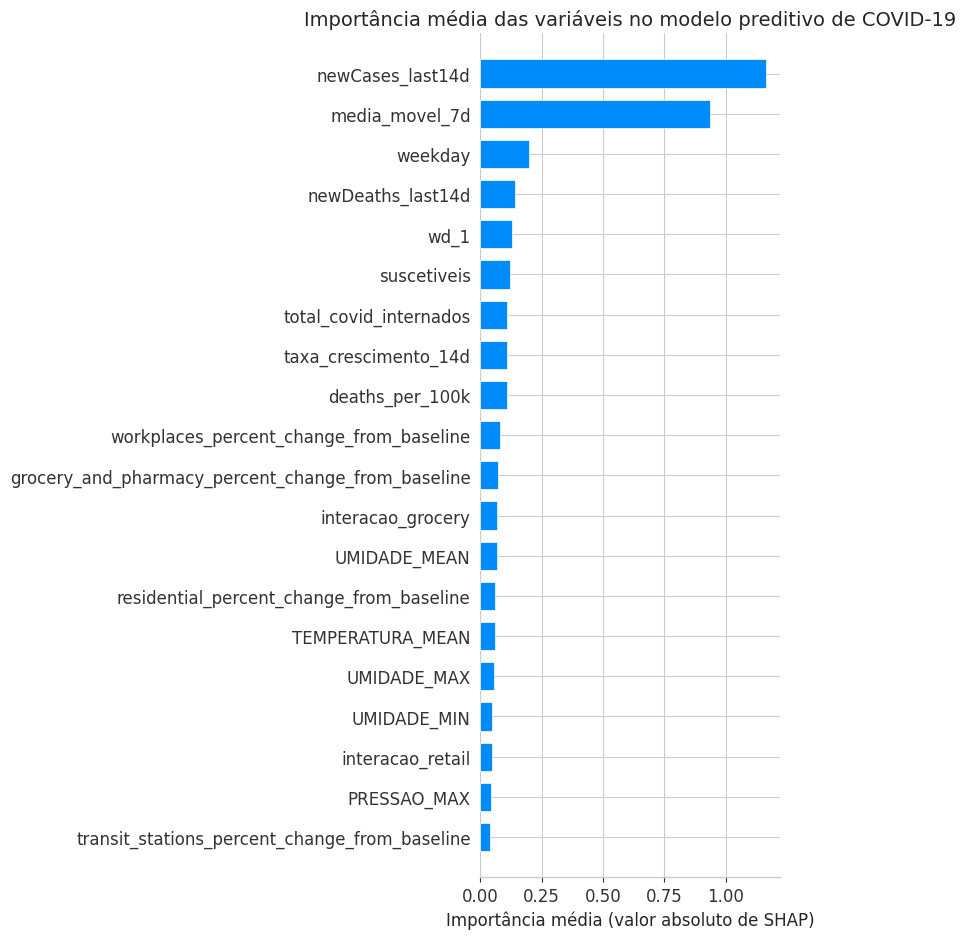

In [75]:
# Carregar modelo e features
melhor_modelo_treinado = joblib.load('melhor_modelo_xgboost.joblib')
features = joblib.load('features_selecionadas.joblib')

# Carregar e preparar dados
df_model = df_filtrado_maior100k.copy()
df_model = df_model[df_model['newCases'] >= 0].copy()
df_model = df_model.dropna(subset=features + ['newCases'])

X = df_model[features]
y = np.sqrt(df_model['newCases'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Previsões treino e teste
y_pred_train = np.square(melhor_modelo_treinado.predict(X_train))
y_train_orig = np.square(y_train)
r2_train = r2_score(y_train_orig, y_pred_train)

y_pred_test = np.square(melhor_modelo_treinado.predict(X_test))
y_test_orig = np.square(y_test)
r2_test = r2_score(y_test_orig, y_pred_test)

# Impressão dos resultados de desempenho
print(f"R² no treino: {r2_train:.4f}")
print(f"R² no teste: {r2_test:.4f}")

# -------- IMPORTÂNCIA DAS FEATURES --------
importancias = melhor_modelo_treinado.feature_importances_
df_importancia = pd.DataFrame({'Feature': features, 'Importância': importancias})
df_importancia = df_importancia.sort_values(by='Importância', ascending=False)

print("\nImportância das Features:")
print(df_importancia.to_string(index=False))

# -------- SHAP EXPLAINER --------
# Converte bool para int
X_train_numeric = X_train.copy()
bool_cols = X_train_numeric.select_dtypes(include=['bool']).columns
X_train_numeric[bool_cols] = X_train_numeric[bool_cols].astype(int)

X_test_numeric = X_test.copy()
X_test_numeric[bool_cols] = X_test_numeric[bool_cols].astype(int)

# Agora cria o explainer com os dados convertidos
explainer = shap.Explainer(melhor_modelo_treinado, X_train_numeric)
shap_values = explainer(X_test_numeric)

# -------- PLOT SUMMARY --------

sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))

# Gerar o gráfico SHAP (sem exibir ainda)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)

# Personalizações
plt.title("Importância média das variáveis no modelo preditivo de COVID-19", fontsize=14)
plt.xlabel("Importância média (valor absoluto de SHAP)", fontsize=12)  # ← alterado aqui!
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Salvar imagem
plt.savefig("shap_summary_barplot.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [56]:
# ---------- PARÂMETROS GERAIS ----------
S, L, I, R, D = 0, 1, 2, 3, 4

faixas_etarias = [(0, 19), (20, 39), (40, 59), (60, 100)]
suscetibilidade_faixa = [0.5, 0.8, 1.0, 1.3]
fracao_clinica_faixa = [0.2, 0.4, 0.7, 0.9]

p_mask = 0.6
lambda_days = 5
theta_days = 7
p_death = 0.02
p_movimento = 0.4
movimentos_por_dia = 2
dias_simulados = 180

# p_mask = 0.4
# p_movimento = 0.5
# movimentos_por_dia = 3

# S: azul claro, L: amarelo, I: vermelho, R: verde, D: cinza escuro
cmap = ListedColormap(["#add8e6", "#ffff99", "#ff4c4c", "#90ee90", "#696969"])

In [57]:
# ---------- CARREGAR MODELO PREDITIVO E FEATURES ----------

modelo_preditor = joblib.load('melhor_modelo_xgboost.joblib')
features_usadas = joblib.load('features_selecionadas.joblib')

# ---------- FUNÇÃO PARA OBTER FEATURES ATUALIZADAS ----------

def obter_features_atualizadas(nome_distrito, data_atual):
    dados = df_model[(df_model['city'] == nome_distrito) & (df_model['date'] == data_atual)]
    if dados.empty:
        dados = df_model[(df_model['city'] == nome_distrito) & (df_model['date'] <= data_atual)].tail(1)
    X = dados[features_usadas]
    if X.empty:
        X = pd.DataFrame([np.zeros(len(features_usadas))], columns=features_usadas)
    return X

In [58]:
class Distrito:
    def __init__(self, nome: str, tamanho: int, populacao: int = None, p_ocupacao: float = 0.6, infectados_iniciais: int = 0):
        self.nome = nome
        self.n = tamanho
        self.populacao = populacao
        self.grade = np.full((self.n, self.n), None)
        self.inicializar_grade(populacao, p_ocupacao, infectados_iniciais)

    def inicializar_grade(self, populacao: int, p_ocupacao: float, infectados_iniciais: int):
        total_celulas = self.n * self.n
        if populacao is not None:
            if populacao > total_celulas:
                raise ValueError(f"População ({populacao}) maior que células ({total_celulas})")
            posicoes = [(i, j) for i in range(self.n) for j in range(self.n)]
            np.random.shuffle(posicoes)
            for k in range(populacao):
                i, j = posicoes[k]
                self.grade[i, j] = self.criar_agente()
        else:
            for i in range(self.n):
                for j in range(self.n):
                    if np.random.rand() < p_ocupacao:
                        self.grade[i, j] = self.criar_agente()
        self.infectar_inicialmente(infectados_iniciais)

    def infectar_inicialmente(self, infectados_iniciais: int):
        ocupadas = [(i, j) for i in range(self.n) for j in range(self.n) if self.grade[i, j] is not None]
        np.random.shuffle(ocupadas)
        for i, j in ocupadas[:max(1, infectados_iniciais)]:
            self.grade[i, j]['estado'] = I

    def criar_agente(self):
        idade = np.random.randint(0, 100)
        fracao_clinica = self.get_fracao_clinica(idade)
        return {
            'estado': S,
            'dias': 0,
            'idade': idade,
            'mascara': np.random.rand() < p_mask,
            'assintomatico': np.random.rand() > fracao_clinica
        }

    def get_suscetibilidade(self, idade):
        for (faixa, s) in zip(faixas_etarias, suscetibilidade_faixa):
            if faixa[0] <= idade <= faixa[1]:
                return s
        return 1.0

    def get_fracao_clinica(self, idade):
        for (faixa, f) in zip(faixas_etarias, fracao_clinica_faixa):
            if faixa[0] <= idade <= faixa[1]:
                return f
        return 0.5

    def vizinhos(self, i, j, raio=1):
        return [(i+di, j+dj) for di in range(-raio, raio+1) for dj in range(-raio, raio+1)
                if (di != 0 or dj != 0) and 0 <= i+di < self.n and 0 <= j+dj < self.n]

    def mover_agente(self, i, j):
        agente = self.grade[i, j]
        if agente is None or np.random.rand() > p_movimento:
            return
        for _ in range(movimentos_por_dia):
            viz = self.vizinhos(i, j)
            np.random.shuffle(viz)
            for vi, vj in viz:
                if self.grade[vi, vj] is None:
                    self.grade[vi, vj] = agente
                    self.grade[i, j] = None
                    return

    def mostrar(self, dia):
        matriz = np.full((self.n, self.n), -1)
        for i in range(self.n):
            for j in range(self.n):
                if self.grade[i, j] is not None:
                    matriz[i, j] = self.grade[i, j]['estado']
        plt.imshow(matriz, cmap=cmap, vmin=0, vmax=4)
        plt.title(f"{self.nome} - Dia {dia}")
        plt.axis('off')
        plt.show()

    def contar_estados(self):
        cont = {S: 0, L: 0, I: 0, R: 0, D: 0}
        for i in range(self.n):
            for j in range(self.n):
                if self.grade[i, j] is not None:
                    cont[self.grade[i, j]['estado']] += 1
        return cont

    def movimentar(self):
        for i in range(self.n):
            for j in range(self.n):
                self.mover_agente(i, j)

    def atualizar(self, data_atual):
        nova = np.copy(self.grade)

        # Previsão do modelo
        features_atualizadas = obter_features_atualizadas(self.nome, data_atual)
        y_pred_sqrt = modelo_preditor.predict(features_atualizadas)[0]
        casos_previstos = int(round(y_pred_sqrt ** 2))

        # Lista de suscetíveis com infectados vizinhos
        suscetiveis_alvo = []
        for i in range(self.n):
            for j in range(self.n):
                agente = self.grade[i, j]
                if agente is None or agente['estado'] != S:
                    continue
                vizinhos = self.vizinhos(i, j)
                if any(self.grade[vi, vj] is not None and self.grade[vi, vj]['estado'] == I for vi, vj in vizinhos):
                    suscetiveis_alvo.append((i, j))

        np.random.shuffle(suscetiveis_alvo)
        novos_infectados = min(casos_previstos, len(suscetiveis_alvo))

        infectados_adicionados = 0

        for i, j in suscetiveis_alvo:
            if infectados_adicionados >= casos_previstos:
                break
            agente = self.grade[i, j]
            susc = self.get_suscetibilidade(agente['idade'])
            if np.random.rand() < susc:
                nova[i, j] = agente.copy()
                nova[i, j]['estado'] = L
                nova[i, j]['dias'] = 0
                infectados_adicionados += 1


        # Transições L → I e I → R/D
        for i in range(self.n):
            for j in range(self.n):
                agente = self.grade[i, j]
                if agente is None:
                    continue
                estado, dias = agente['estado'], agente['dias']

                if estado == L and dias >= lambda_days:
                    nova[i, j]['estado'] = I
                    nova[i, j]['dias'] = 0
                elif estado == I and dias >= theta_days:
                    nova[i, j]['estado'] = D if np.random.rand() < p_death else R
                    nova[i, j]['dias'] = 0
                elif estado in [L, I]:
                    nova[i, j]['dias'] += 1

        self.grade = nova
        print(f"[{self.nome}] {data_atual.date()} - Prev: {casos_previstos}, Alvo possíveis: {len(suscetiveis_alvo)}, Aplicados: {novos_infectados}")



    def migrar_para(self, outro, taxa=0.01):
        candidatos = [(i, j, self.grade[i, j]) for i in range(self.n) for j in range(self.n)
                      if self.grade[i, j] and self.grade[i, j]['estado'] in [S, L, I, R] and np.random.rand() < taxa]
        for i, j, agente in candidatos:
            self.grade[i, j] = None
            for _ in range(20):
                x, y = np.random.randint(0, outro.n), np.random.randint(0, outro.n)
                if outro.grade[x, y] is None:
                    outro.grade[x, y] = agente
                    break


In [59]:
# ---------- CONFIGURAÇÃO DA SIMULAÇÃO ----------
inicio_simulacao = pd.to_datetime("2020-05-01")
janela_inicial = 7
inicio_janela = inicio_simulacao - pd.Timedelta(days=janela_inicial)
fim_janela = inicio_simulacao - pd.Timedelta(days=1)

# ---------- FILTRA E AGREGA DADOS COVID ----------
df_final_covid['date'] = pd.to_datetime(df_final_covid['date'])

df_pre_simulacao = df_final_covid[
    (df_final_covid['date'] >= inicio_janela) &
    (df_final_covid['date'] <= fim_janela)
]

df_infectados = (
    df_pre_simulacao
    .groupby('city', as_index=False)['newCases']
    .sum()
    .rename(columns={'newCases': 'infectados_iniciais'})
)

# ---------- DADOS DAS CIDADES ----------
df_cidades = df_final_covid.drop_duplicates(subset='city')[
    ['city', 'pop2020', 'VL_LATITUDE', 'VL_LONGITUDE']
].copy()

df_cidades['pop2020'] = df_cidades['pop2020'].astype(int)
df_cidades['lat'] = df_cidades['VL_LATITUDE'].apply(lambda x: float(x.replace(',', '.')))
df_cidades['lon'] = df_cidades['VL_LONGITUDE'].apply(lambda x: float(x.replace(',', '.')))
df_cidades = df_cidades[df_cidades['pop2020'] > 100000]

df_cidades = df_cidades.merge(df_infectados, on='city', how='left')
df_cidades = df_cidades.fillna(0)

In [60]:
def calcula_tamanho_grade(populacao, fator_folga=1.5):
    n_celulas = populacao * fator_folga
    return int(ceil(sqrt(n_celulas)))

coords = np.array(list(zip(df_cidades['lat'], df_cidades['lon'])))
k = 4
fator_folga = 1.5

G_approx = nx.Graph()
tree = KDTree(coords)


for i, city in enumerate(df_cidades['city']):
    G_approx.add_node(city, lat=coords[i, 0], lon=coords[i, 1])

    dists, idxs = tree.query(coords[i].reshape(1, -1), k=k + 1)
    for dist, idx in zip(dists[0][1:], idxs[0][1:]):
        city2 = df_cidades.iloc[idx]['city']
        G_approx.add_edge(city, city2, weight=dist)

for city in G_approx.nodes():
    linha = df_cidades[df_cidades['city'] == city]
    pop = int(linha['pop2020'].values[0])
    infectados = int(linha['infectados_iniciais'].values[0])
    tam_grade = calcula_tamanho_grade(pop, fator_folga)

    G_approx.nodes[city]['populacao'] = pop
    G_approx.nodes[city]['infectados_iniciais'] = infectados
    G_approx.nodes[city]['tamanho_grade'] = tam_grade


dados_iniciais = []

for city in G_approx.nodes():
    pop = G_approx.nodes[city]['populacao']
    inf = G_approx.nodes[city]['infectados_iniciais']
    prop_inf = inf / pop if pop > 0 else 0
    dados_iniciais.append({
        'city': city,
        'populacao': pop,
        'infectados_iniciais': inf,
        'proporcao_infectados': prop_inf
    })

df_inicial = pd.DataFrame(dados_iniciais)
df_inicial.sort_values(by='proporcao_infectados', ascending=False, inplace=True)


if 'proporcao_infectados' not in df_model.columns:
    df_model = df_model.merge(df_inicial[['city', 'proporcao_infectados']], on='city', how='left')
    df_model['proporcao_infectados'] = df_model['proporcao_infectados'].fillna(0)

colunas_modelo_com_proporcao = colunas_modelo + ['proporcao_infectados']

In [61]:
data_inicial = pd.to_datetime("2020-05-01")


df_resultados = []

# --------- LOOP SOBRE CIDADES ---------
for cidade_teste in G_approx.nodes:
    print(f"\n Simulando cidade: {cidade_teste}")

    dados = G_approx.nodes[cidade_teste]

    # Instancia o distrito para essa cidade
    distrito = Distrito(
        nome=cidade_teste,
        tamanho=dados['tamanho_grade'],
        populacao=dados['populacao'],
        infectados_iniciais=dados.get('infectados_iniciais', 0)
    )

    for dia in range(dias_simulados + 1):
        data_atual = data_inicial + pd.Timedelta(days=dia)
        cont = distrito.contar_estados()

        # Armazena no DataFrame
        df_resultados.append({
            'cidade': cidade_teste,
            'data': data_atual,
            'dia_simulado': dia,
            'suscetiveis': cont[S],
            'latentes': cont[L],
            'infectados': cont[I],
            'recuperados': cont[R],
            'mortos': cont[D]
        })

        print(f" Dia {dia} | {data_atual.date()} | {cidade_teste}: S={cont[S]} | L={cont[L]} | I={cont[I]} | R={cont[R]} | D={cont[D]}")

        distrito.movimentar()
        distrito.atualizar(data_atual)


df_resultados = pd.DataFrame(df_resultados)
df_resultados.to_csv("resultados_simulacao_todas_cidades.csv", index=False)

print("\n Simulação concluída e salva em 'resultados_simulacao_todas_cidades.csv'")

A saída de streaming foi truncada nas últimas 5000 linhas.
 Dia 48 | 2020-06-18 | JUIZ DE FORA: S=572518 | L=106 | I=143 | R=505 | D=13
[JUIZ DE FORA] 2020-06-18 - Prev: 16, Alvo possíveis: 545, Aplicados: 16
 Dia 49 | 2020-06-19 | JUIZ DE FORA: S=572502 | L=102 | I=135 | R=533 | D=13
[JUIZ DE FORA] 2020-06-19 - Prev: 25, Alvo possíveis: 489, Aplicados: 25
 Dia 50 | 2020-06-20 | JUIZ DE FORA: S=572477 | L=108 | I=137 | R=550 | D=13
[JUIZ DE FORA] 2020-06-20 - Prev: 47, Alvo possíveis: 487, Aplicados: 47
 Dia 51 | 2020-06-21 | JUIZ DE FORA: S=572430 | L=140 | I=125 | R=577 | D=13
[JUIZ DE FORA] 2020-06-21 - Prev: 24, Alvo possíveis: 431, Aplicados: 24
 Dia 52 | 2020-06-22 | JUIZ DE FORA: S=572406 | L=148 | I=130 | R=588 | D=13
[JUIZ DE FORA] 2020-06-22 - Prev: 46, Alvo possíveis: 441, Aplicados: 46
 Dia 53 | 2020-06-23 | JUIZ DE FORA: S=572360 | L=178 | I=135 | R=599 | D=13
[JUIZ DE FORA] 2020-06-23 - Prev: 33, Alvo possíveis: 481, Aplicados: 33
 Dia 54 | 2020-06-24 | JUIZ DE FORA: S=57

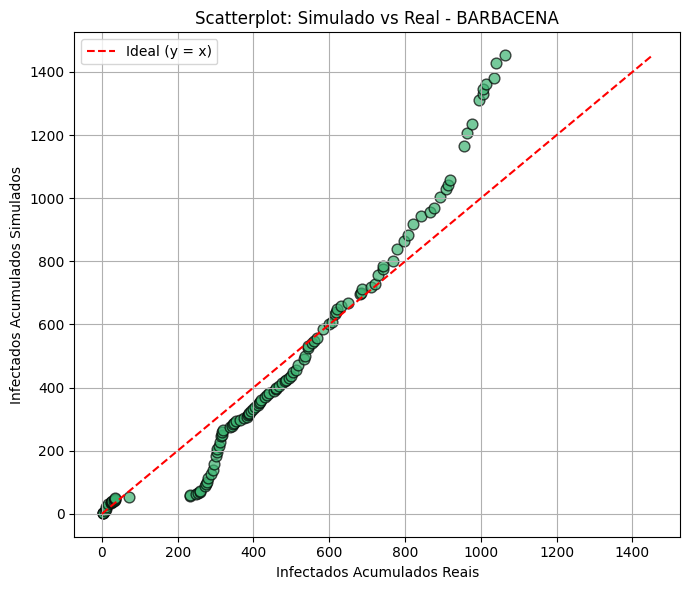

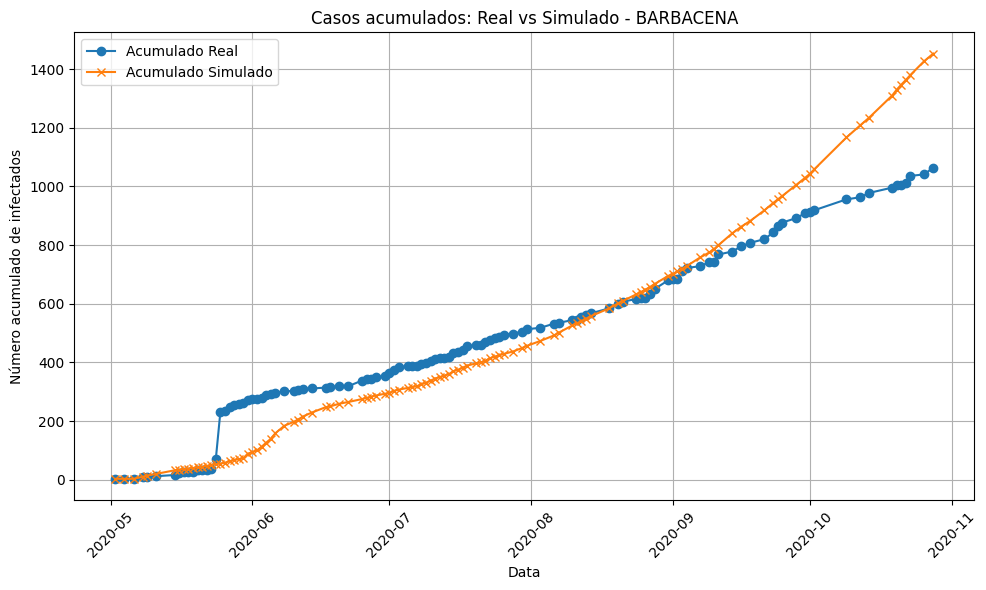

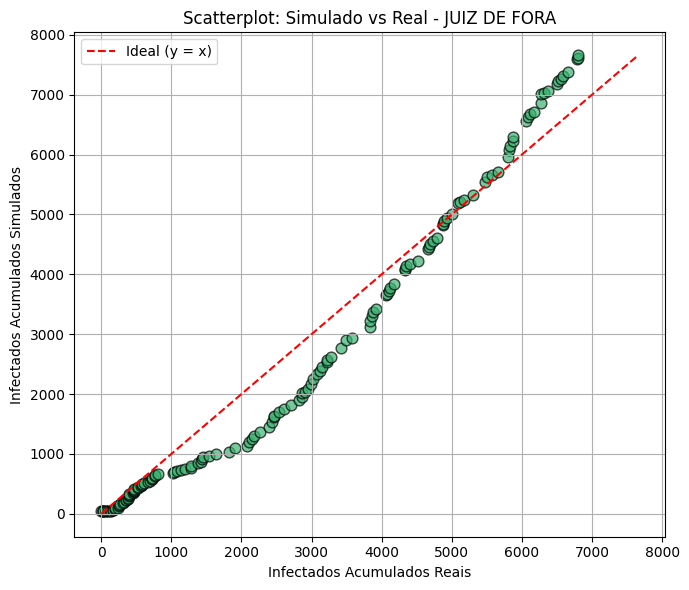

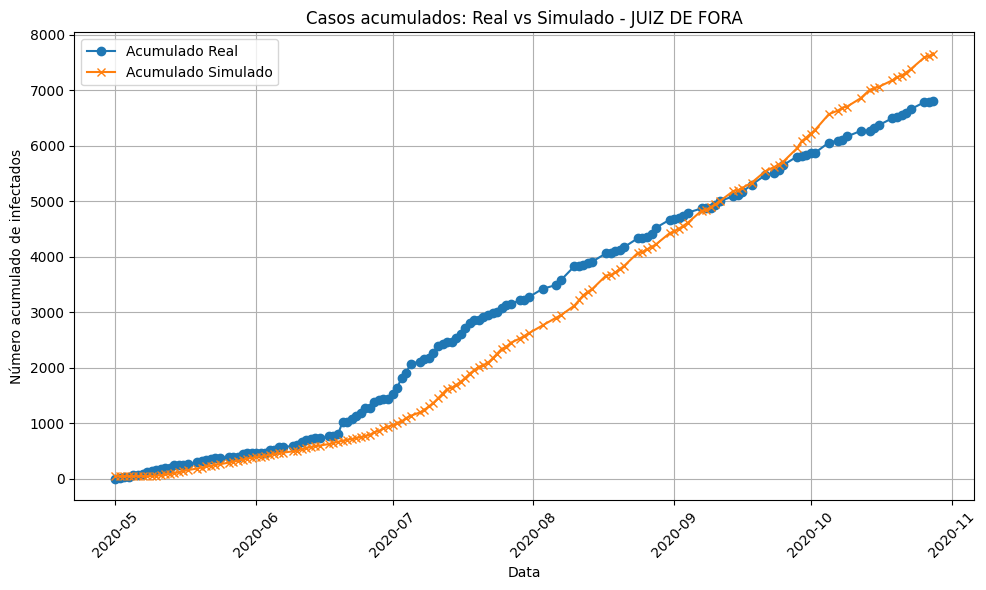

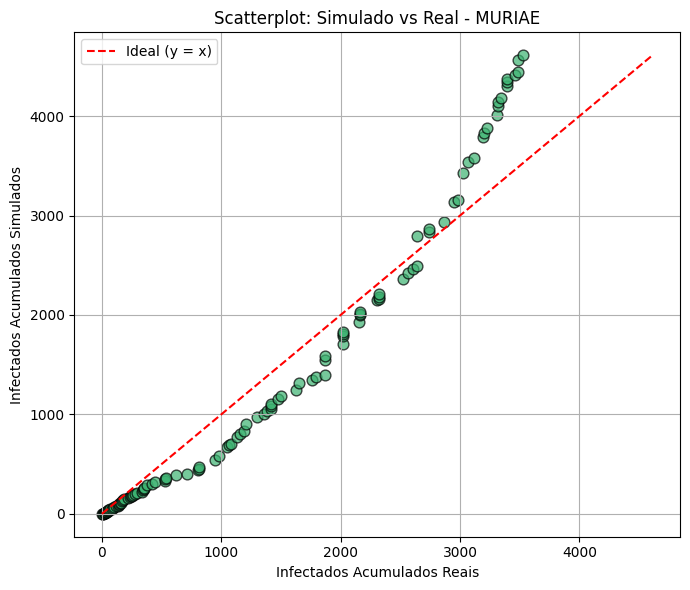

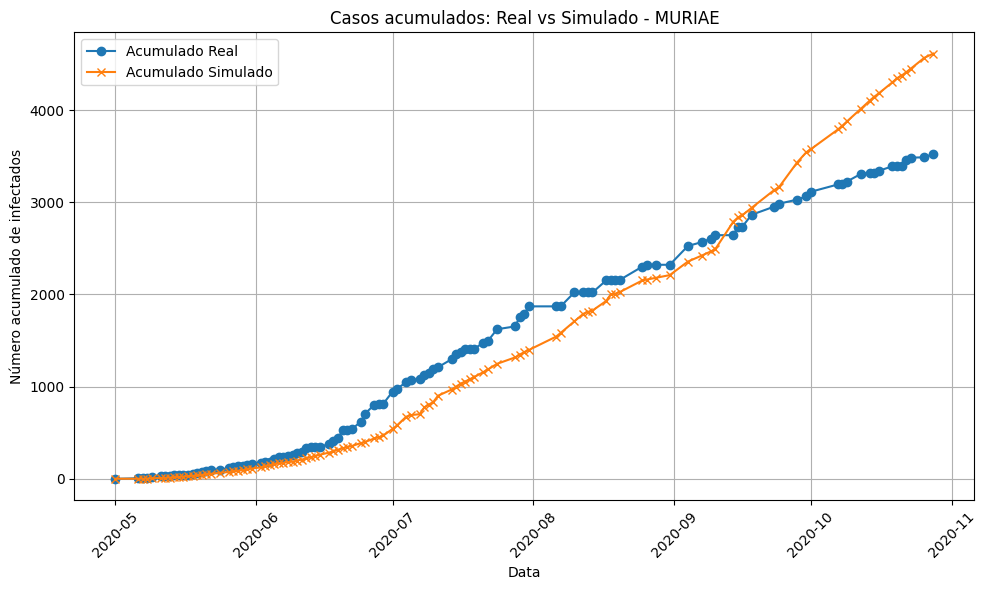

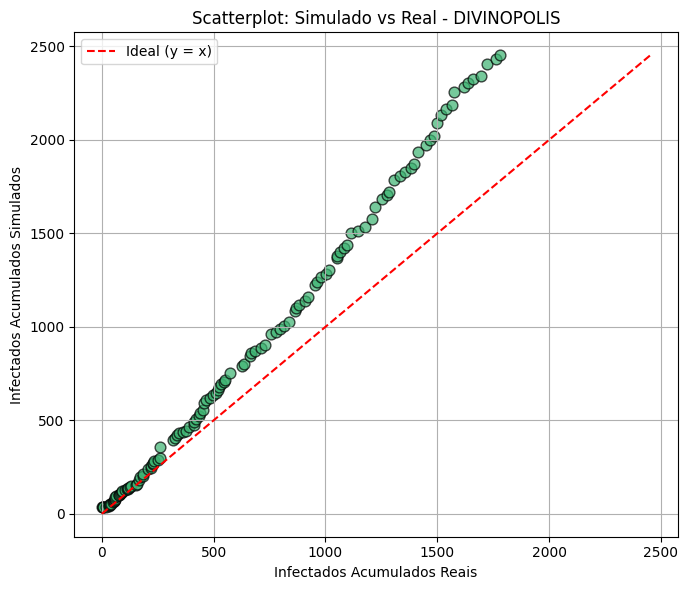

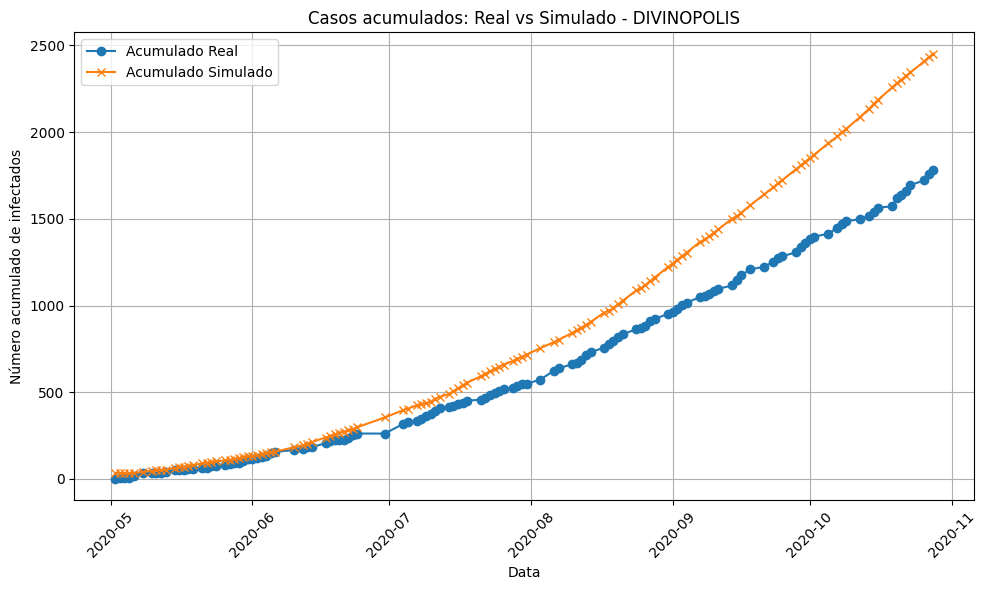

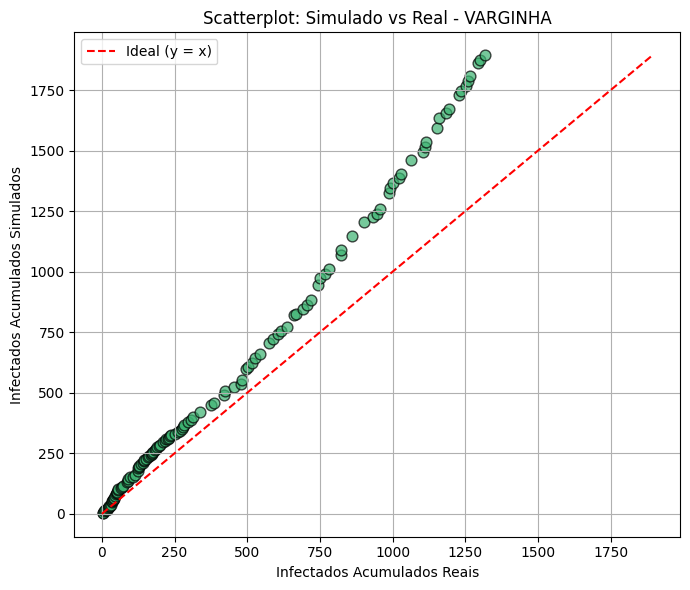

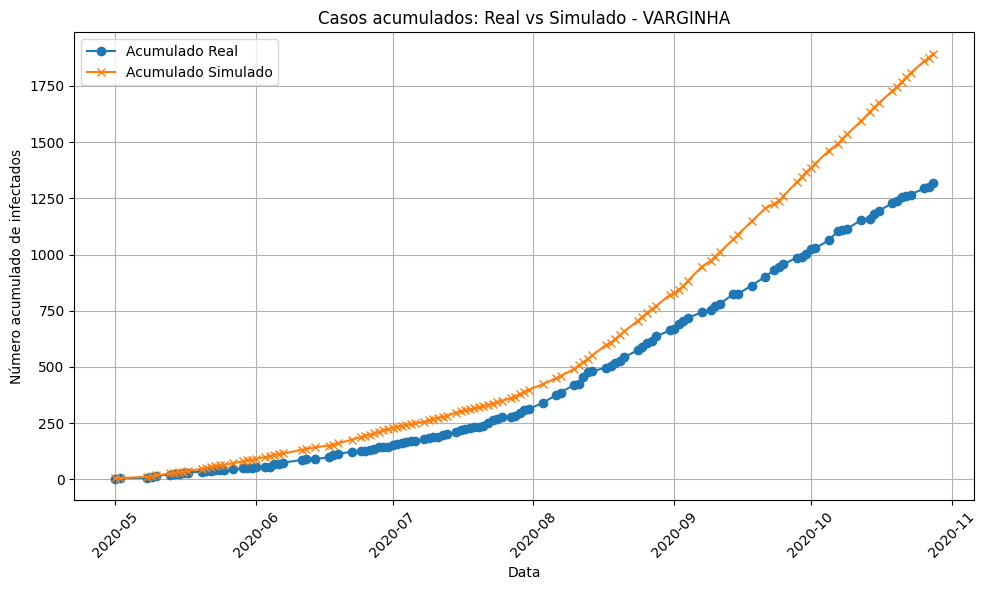

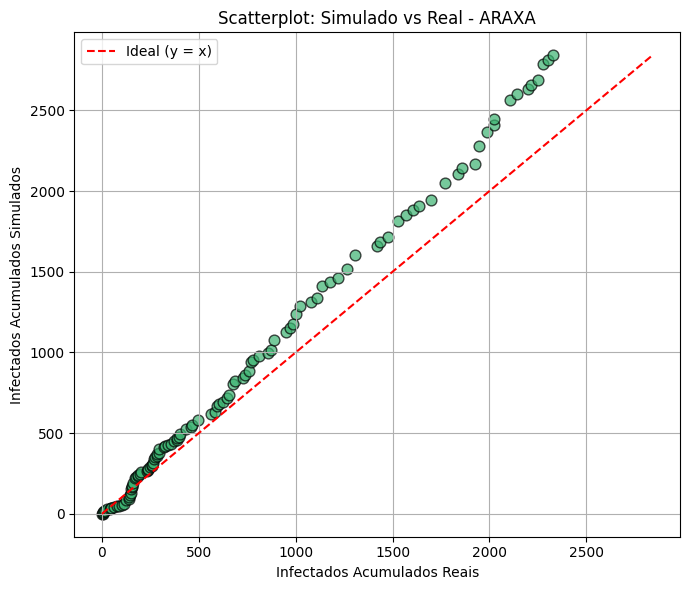

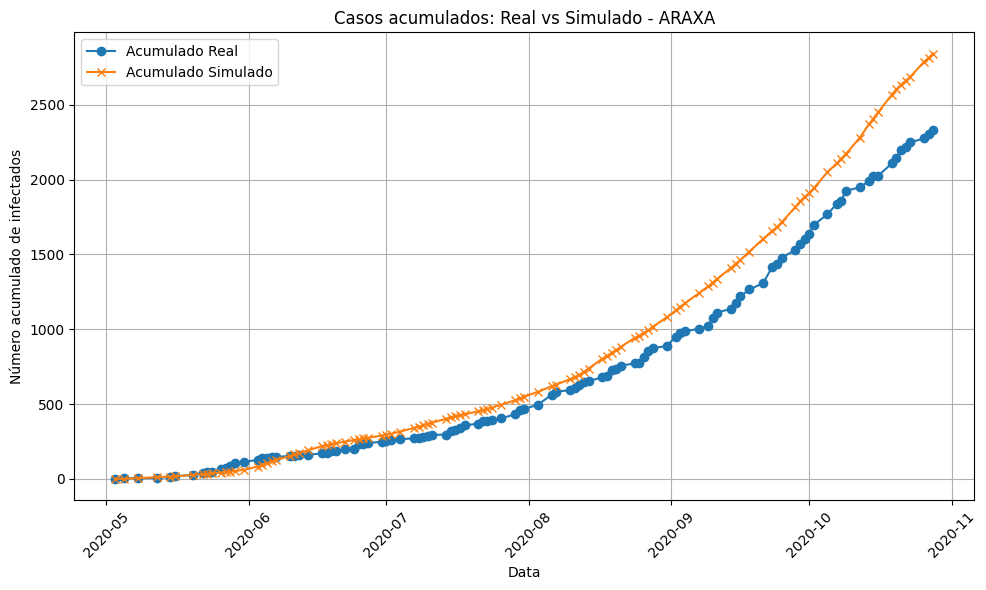

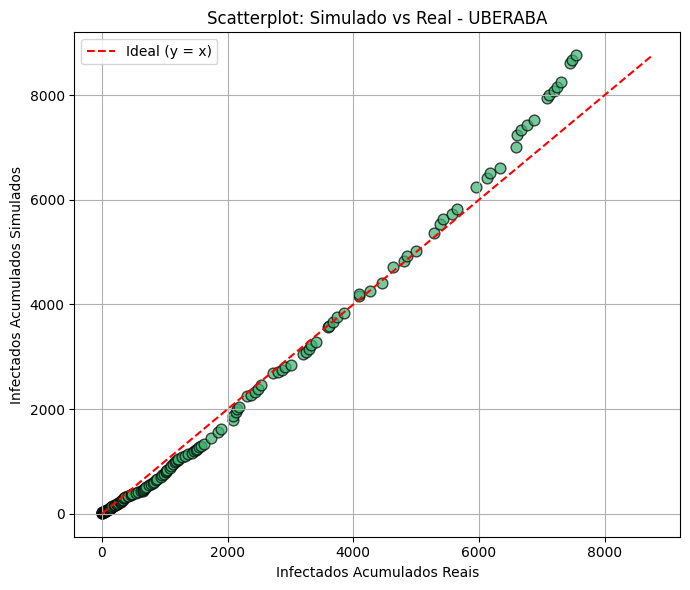

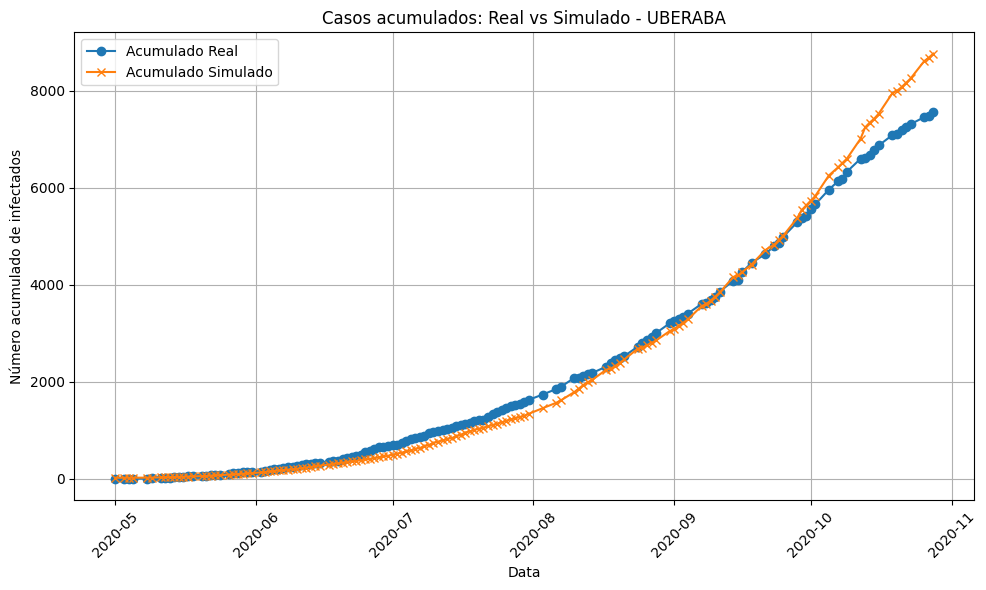

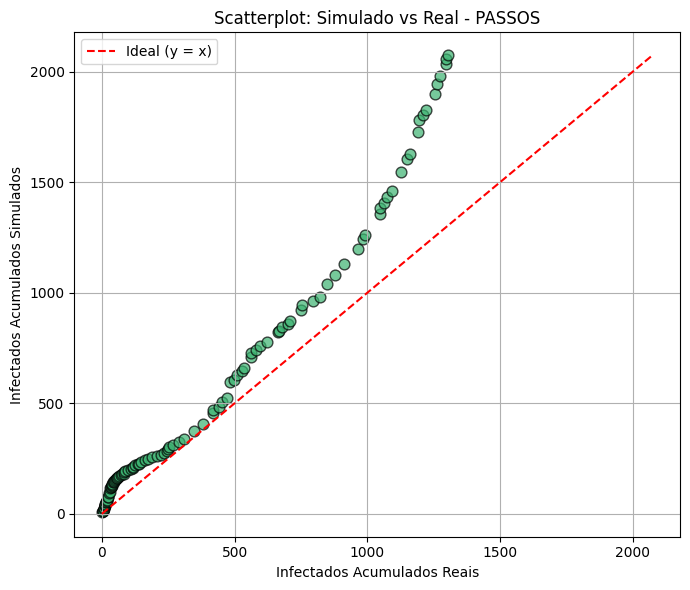

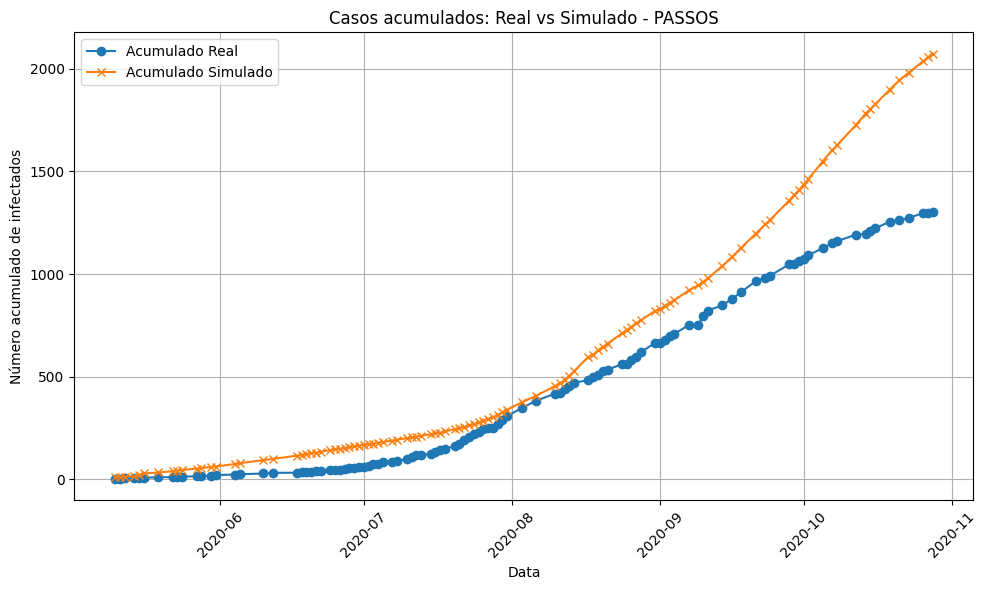

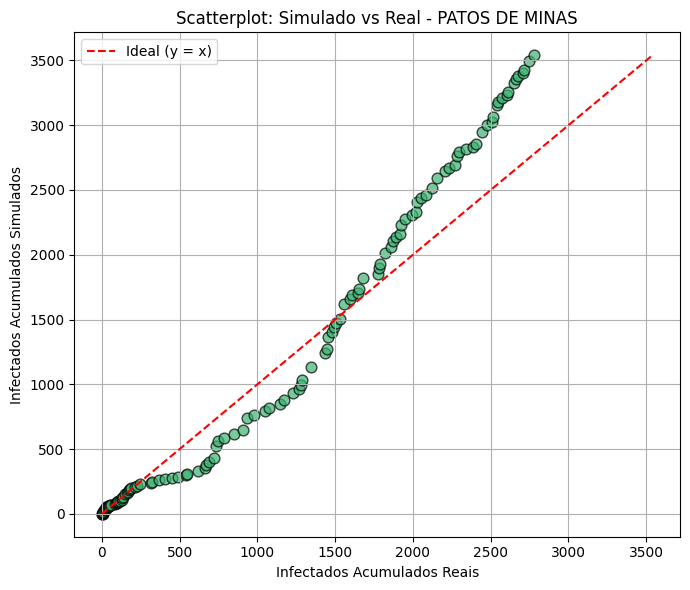

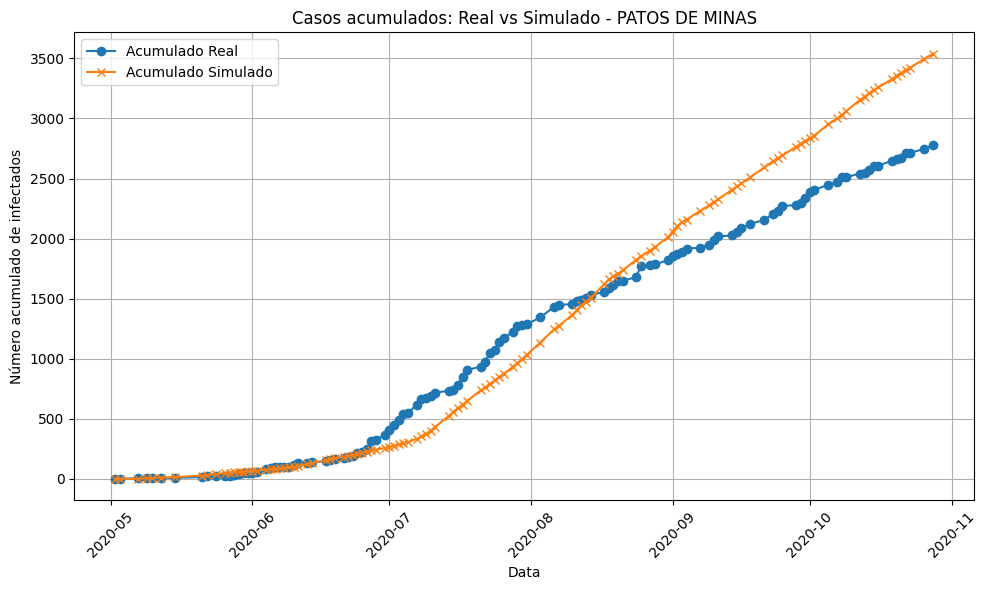

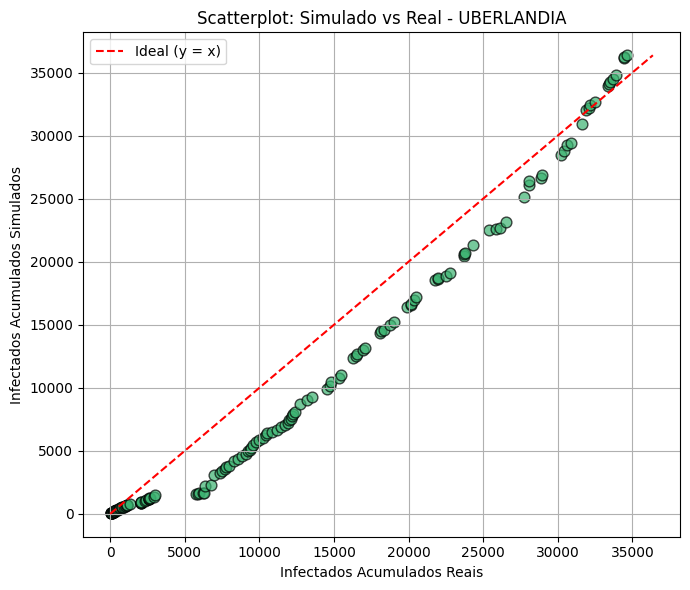

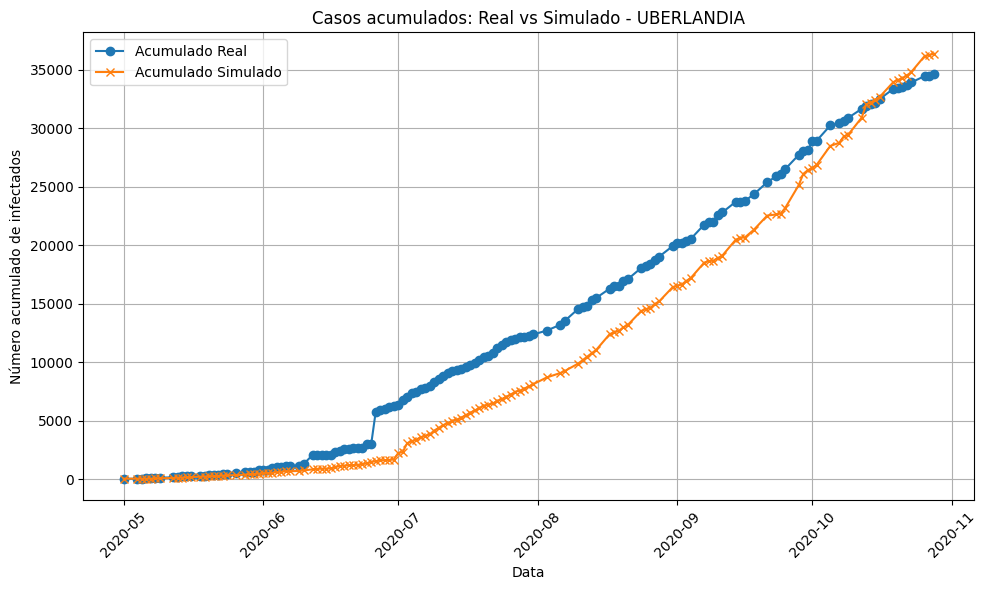

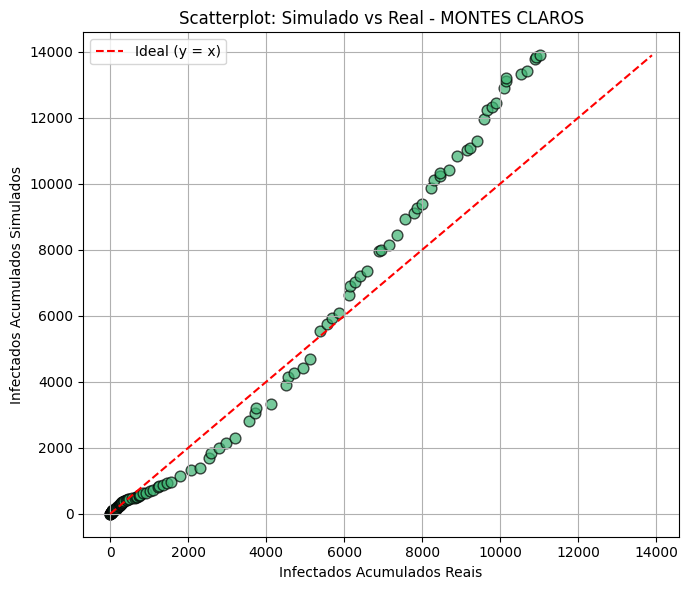

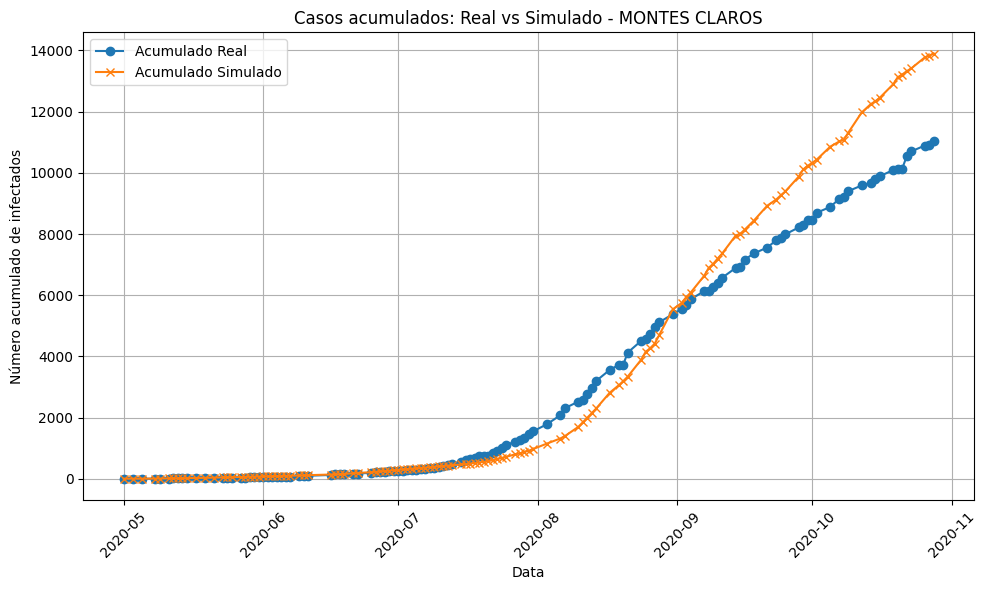

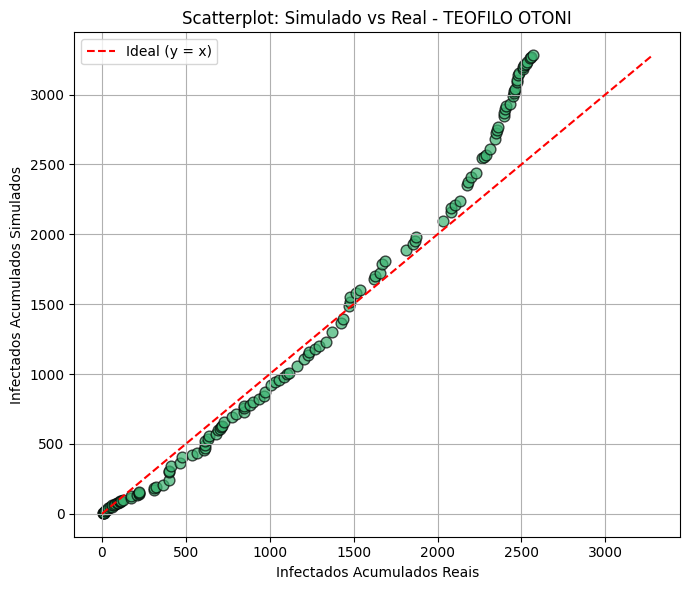

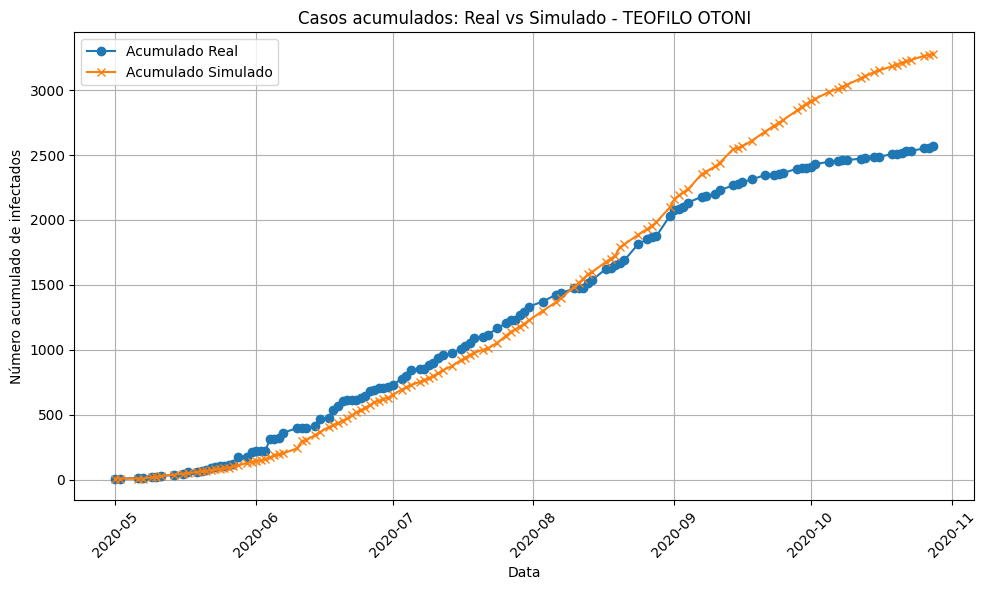

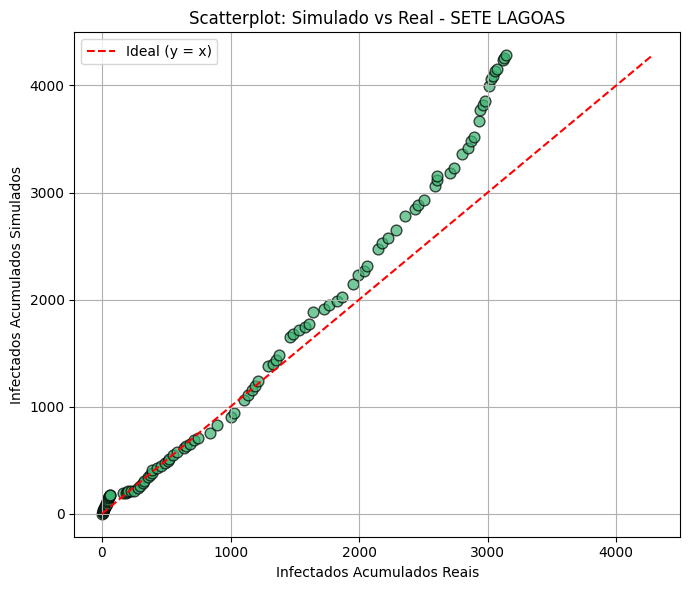

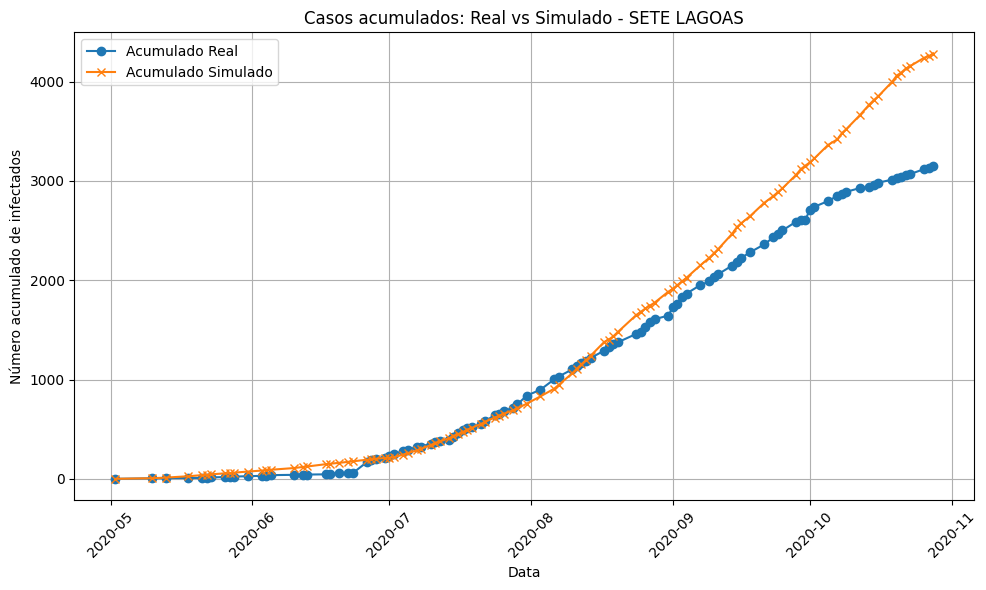

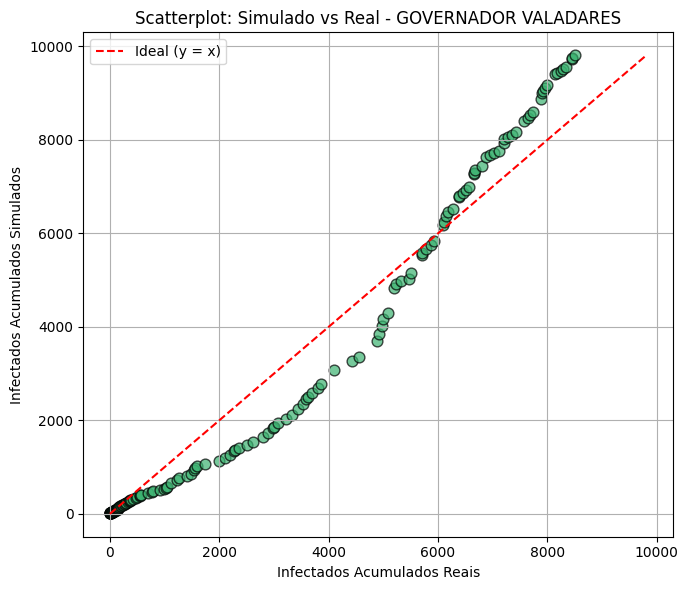

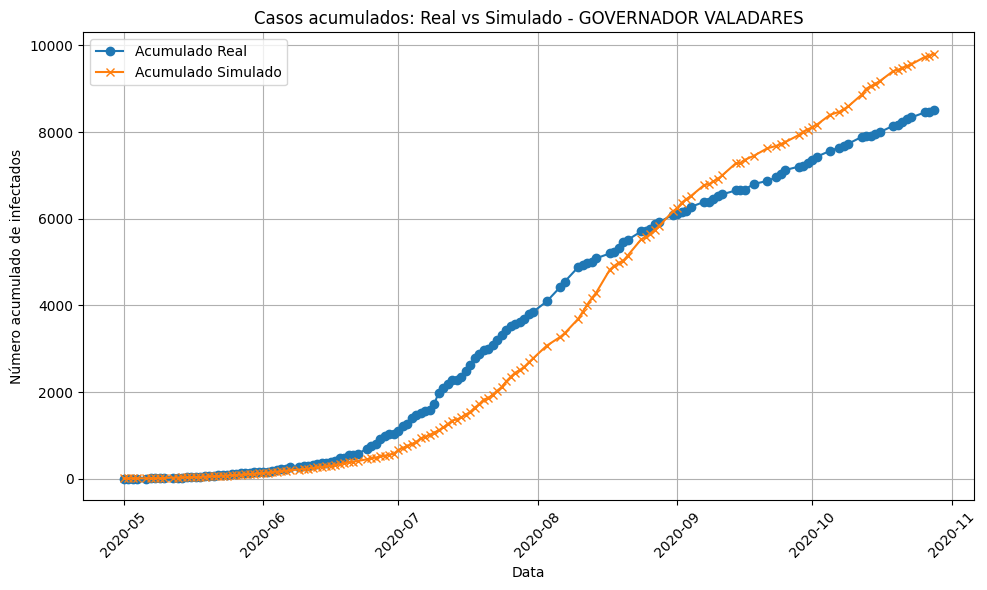

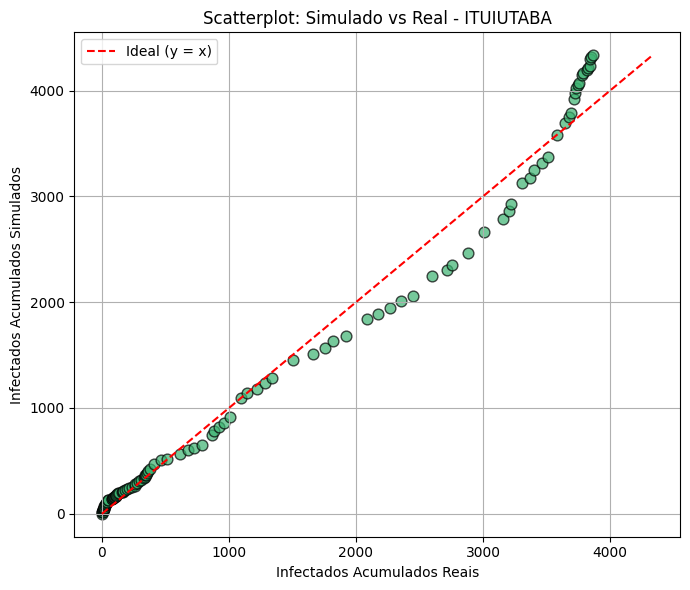

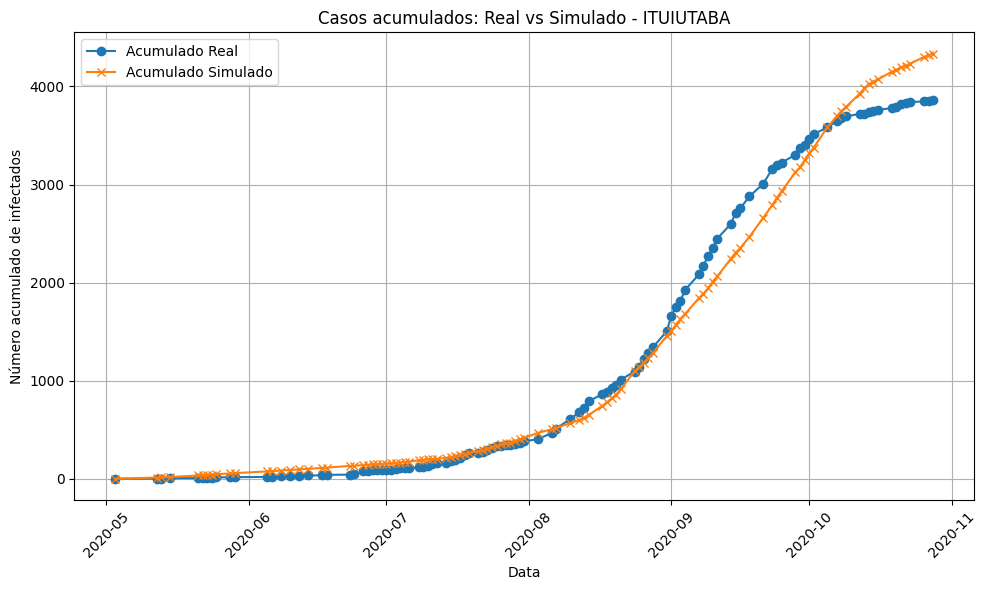


 Teste de Wilcoxon (totais finais):
W = 0.0000, p-valor = 0.0001
 Diferença significativa (não-paramétrico)


In [62]:
df_resultados = pd.read_csv("resultados_simulacao_todas_cidades.csv", parse_dates=["data"])
df_resultados['newCases_sim'] = df_resultados[['infectados', 'recuperados']].sum(axis=1)

os.makedirs("scatterplot_por_cidade", exist_ok=True)


metricas = []
totais_reais = []
totais_simulados = []

cidades_simuladas = df_resultados['cidade'].unique()

for cidade in cidades_simuladas:
    # Filtra dados simulados
    sim = df_resultados[df_resultados['cidade'] == cidade].sort_values('data')

    # Dados reais
    reais = df_model[df_model['city'] == cidade].copy()
    reais['date'] = pd.to_datetime(reais['date'])
    reais = reais[(reais['date'] >= sim['data'].min()) & (reais['date'] <= sim['data'].max())]
    reais['infectados_acumulados_real'] = reais['newCases'].cumsum()

    # Combina simulação com dados reais
    df_comp = pd.merge(sim[['data', 'newCases_sim']],
                       reais[['date', 'infectados_acumulados_real']],
                       left_on='data', right_on='date', how='inner')

    if df_comp.empty:
        print(f"{cidade} sem dados reais no período da simulação.")
        continue

    # Avaliação
    y_real = df_comp['infectados_acumulados_real'].values
    y_pred = df_comp['newCases_sim'].values

    mae = mean_absolute_error(y_real, y_pred)
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    r2 = r2_score(y_real, y_pred)

    total_real = y_real[-1]
    total_simulado = y_pred[-1]

    metricas.append({
        'cidade': cidade,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'Total_Real': total_real,
        'Total_Simulado': total_simulado
    })

    totais_reais.append(total_real)
    totais_simulados.append(total_simulado)

    # --------- GRÁFICO 1: Scatterplot ---------
    plt.figure(figsize=(7,6))
    plt.scatter(y_real, y_pred, color='mediumseagreen', edgecolor='k', alpha=0.7, s=60)
    max_val = max(y_real.max(), y_pred.max())
    plt.plot([0, max_val], [0, max_val], 'r--', label='Ideal (y = x)')
    plt.xlabel('Infectados Acumulados Reais')
    plt.ylabel('Infectados Acumulados Simulados')
    plt.title(f'Scatterplot: Simulado vs Real - {cidade}')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --------- GRÁFICO 2: Linha temporal ---------
    plt.figure(figsize=(10, 6))
    plt.plot(df_comp['data'], y_real, label='Acumulado Real', marker='o')
    plt.plot(df_comp['data'], y_pred, label='Acumulado Simulado', marker='x')
    plt.xlabel('Data')
    plt.ylabel('Número acumulado de infectados')
    plt.title(f'Casos acumulados: Real vs Simulado - {cidade}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Salva métricas
df_metricas = pd.DataFrame(metricas)
df_metricas.to_csv("metricas_simulacao_cidades.csv", index=False)


# Teste estatístico entre totais finais reais e simulados
totais_reais = np.array(totais_reais)
totais_simulados = np.array(totais_simulados)


print("\n Teste de Wilcoxon (totais finais):")
try:
    w_stat, p_w = wilcoxon(totais_reais, totais_simulados)
    print(f"W = {w_stat:.4f}, p-valor = {p_w:.4f}")
    print(" Sem diferença significativa" if p_w >= 0.05 else " Diferença significativa (não-paramétrico)")
except Exception as e:
    print(f" Wilcoxon não pôde ser aplicado: {e}")


In [77]:
display(df_metricas)

,cidade,MAE,RMSE,R2,Total_Real,Total_Simulado
0,BARBACENA,85.862069,123.066775,0.814308,1064,1453
1,JUIZ DE FORA,384.461538,491.278324,0.949646,6803,7658
2,MURIAE,264.517857,374.028432,0.900455,3524,4612
3,DIVINOPOLIS,207.346774,292.434787,0.699157,1780,2453
4,VARGINHA,151.723577,217.568006,0.715055,1318,1894
5,ARAXA,145.490909,198.484852,0.918222,2331,2842
6,UBERABA,187.443662,304.209516,0.982148,7552,8762
7,PASSOS,168.027778,249.859609,0.662665,1303,2074
8,PATOS DE MINAS,222.991667,310.852095,0.890659,2778,3540
9,UBERLANDIA,2405.794326,2958.747570,0.928221,34657,36368


In [64]:
# Junta a proporção e total de infectados no grafo
for i, row in df_metricas.iterrows():
    city = row['cidade']
    total_infectados = row['Total_Simulado']
    proporcao = total_infectados / G_approx.nodes[city]['populacao'] if G_approx.nodes[city]['populacao'] > 0 else 0
    G_approx.nodes[city]['infectados_acumulados'] = total_infectados
    G_approx.nodes[city]['proporcao_infectados'] = proporcao


In [65]:
print(f"Número de nós: {G_approx.number_of_nodes()}")
print(f"Número de arestas: {G_approx.number_of_edges()}")


Número de nós: 15
Número de arestas: 35


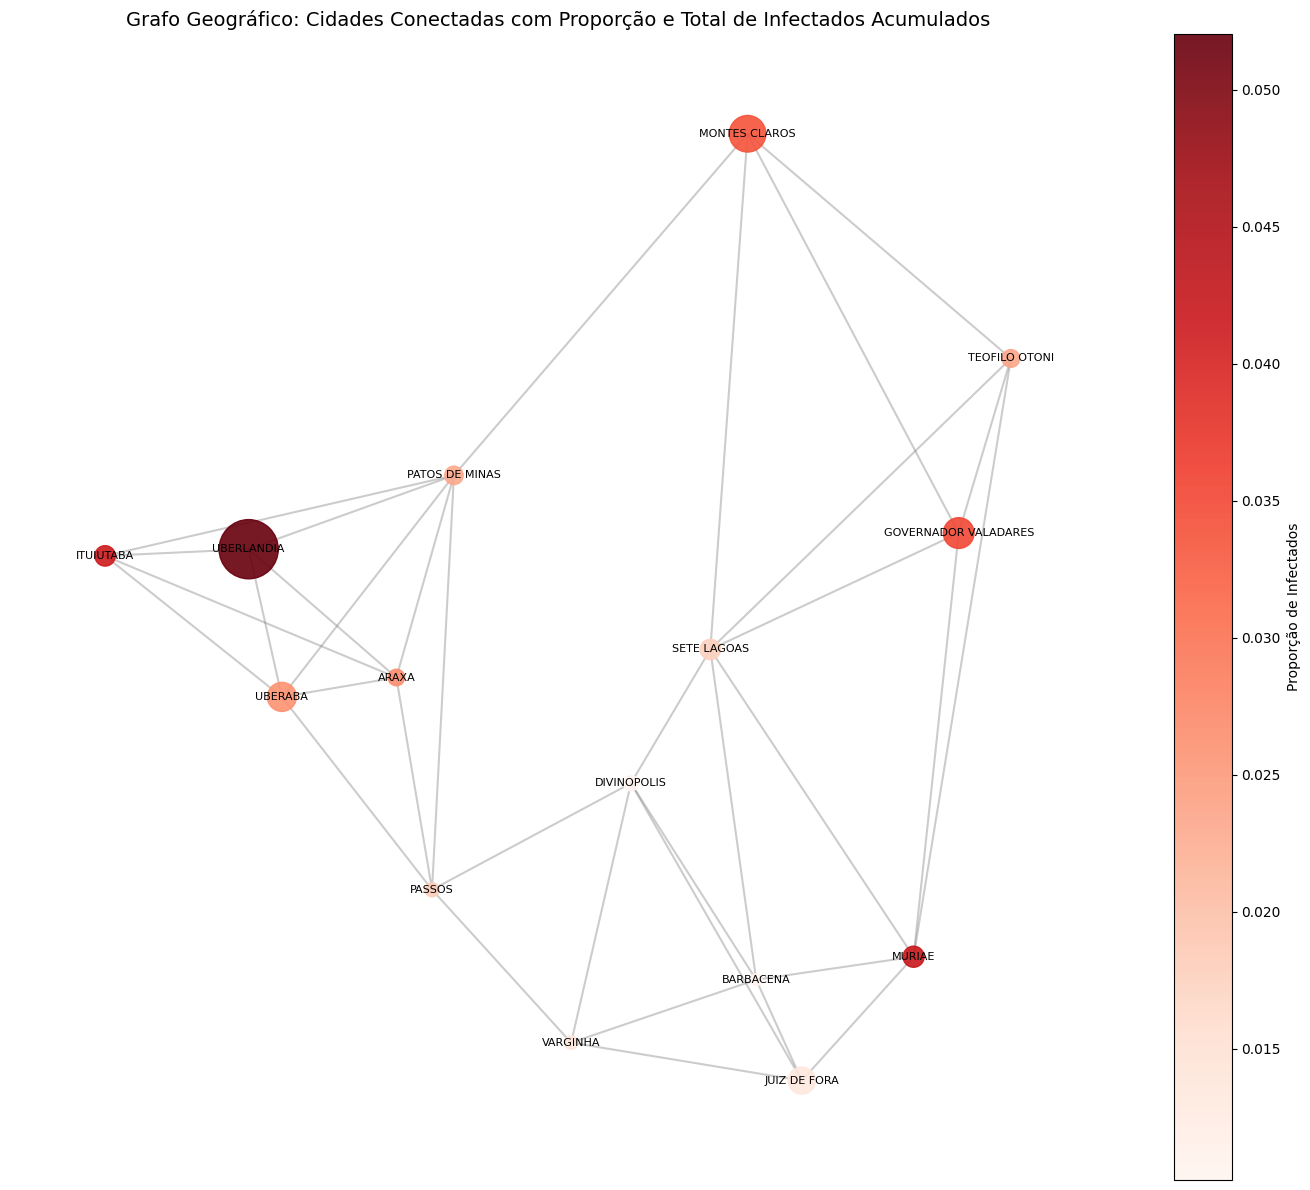

In [66]:
# import matplotlib.pyplot as plt
# import networkx as nx

plt.figure(figsize=(14, 12))

# Posições baseadas em coordenadas geográficas (lon, lat)
pos = {city: (G_approx.nodes[city]['lon'], G_approx.nodes[city]['lat']) for city in G_approx.nodes}

# Tamanho do nó baseado no total de infectados acumulados
node_sizes = [G_approx.nodes[city].get('infectados_acumulados', 0) * 0.05 for city in G_approx.nodes]

# Cor do nó baseada na proporção de infectados
proporcoes = [G_approx.nodes[city].get('proporcao_infectados', 0) for city in G_approx.nodes]

# Desenhar arestas primeiro
nx.draw_networkx_edges(G_approx, pos, edge_color='gray', alpha=0.4, width=1.5)

# Desenhar nós com tamanhos e cores
nodes = nx.draw_networkx_nodes(
    G_approx, pos,
    node_size=node_sizes,
    node_color=proporcoes,
    cmap=plt.cm.Reds,
    alpha=0.9
)

# Rótulos das cidades
nx.draw_networkx_labels(G_approx, pos, font_size=8)

# Barra de cor
cbar = plt.colorbar(nodes)
cbar.set_label('Proporção de Infectados')

plt.title("Grafo Geográfico: Cidades Conectadas com Proporção e Total de Infectados Acumulados", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()
